In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
pip install dabl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.0/559.0 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dabl
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# EDA

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


<AxesSubplot:xlabel='Survived', ylabel='count'>

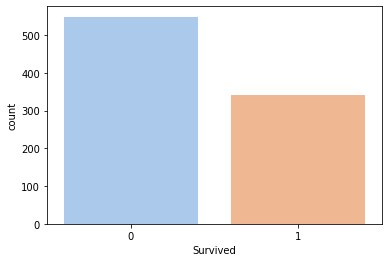

In [9]:
sns.countplot(x=train_df['Survived'], palette='pastel')

In [10]:
def make_countplot(train_df, col):
    sns.countplot(x=train_df['Survived'], palette='pastel', hue=train_df[col])
    plt.tight_layout(rect=(0, 0, 1.2, 1.2))
    plt.show()
#     plt.tight_layout(rect=(0, 0, 1.2, 1.2))
    return None

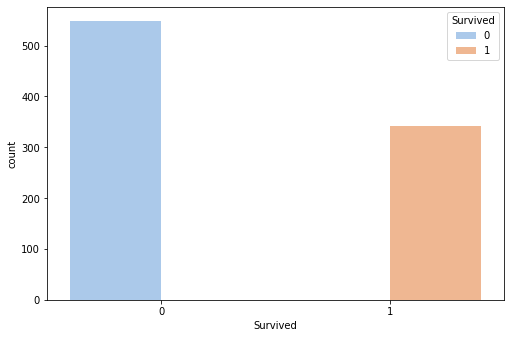

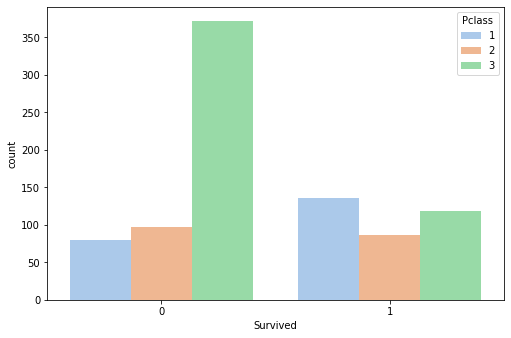

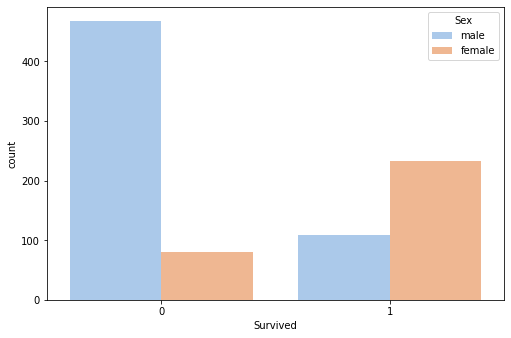

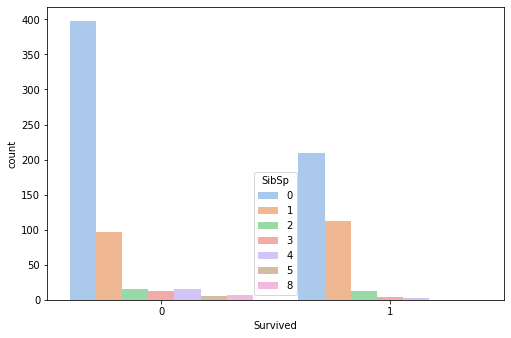

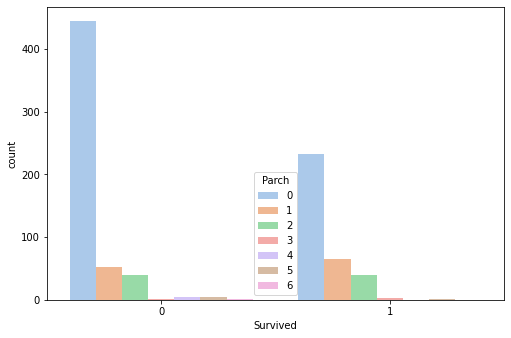

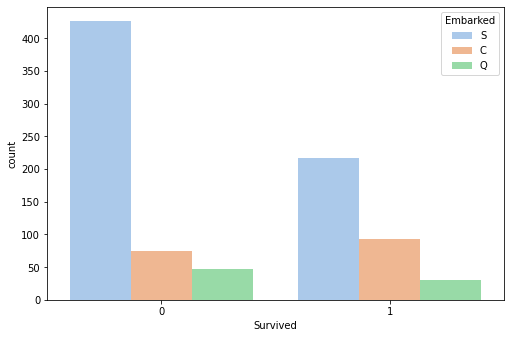

In [11]:
df = train_df.drop(['Age', 'Fare', 'Ticket', 'Cabin'], axis=1)
for col in df.columns:
    make_countplot(df, col)


In [12]:
df = train_df

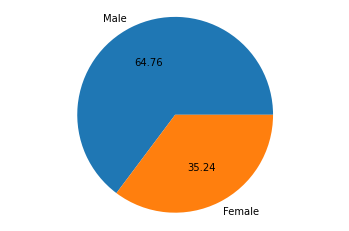

In [13]:
plt.pie(df['Sex'].value_counts(), labels=['Male', 'Female'], autopct='%.2f')
plt.axis('equal')
plt.show()

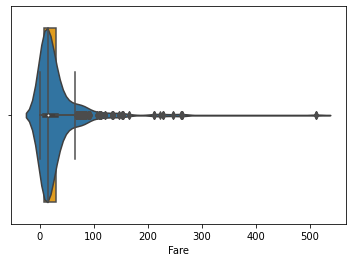

<AxesSubplot:xlabel='Fare', ylabel='Count'>

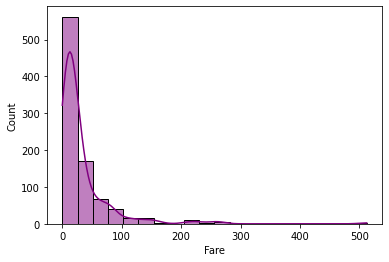

In [14]:
sns.violinplot(x=train_df['Fare'])
sns.boxplot(x=train_df['Fare'], color='orange')
plt.show()
sns.histplot(x=train_df['Fare'], bins=20, kde=True, color='purple')

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


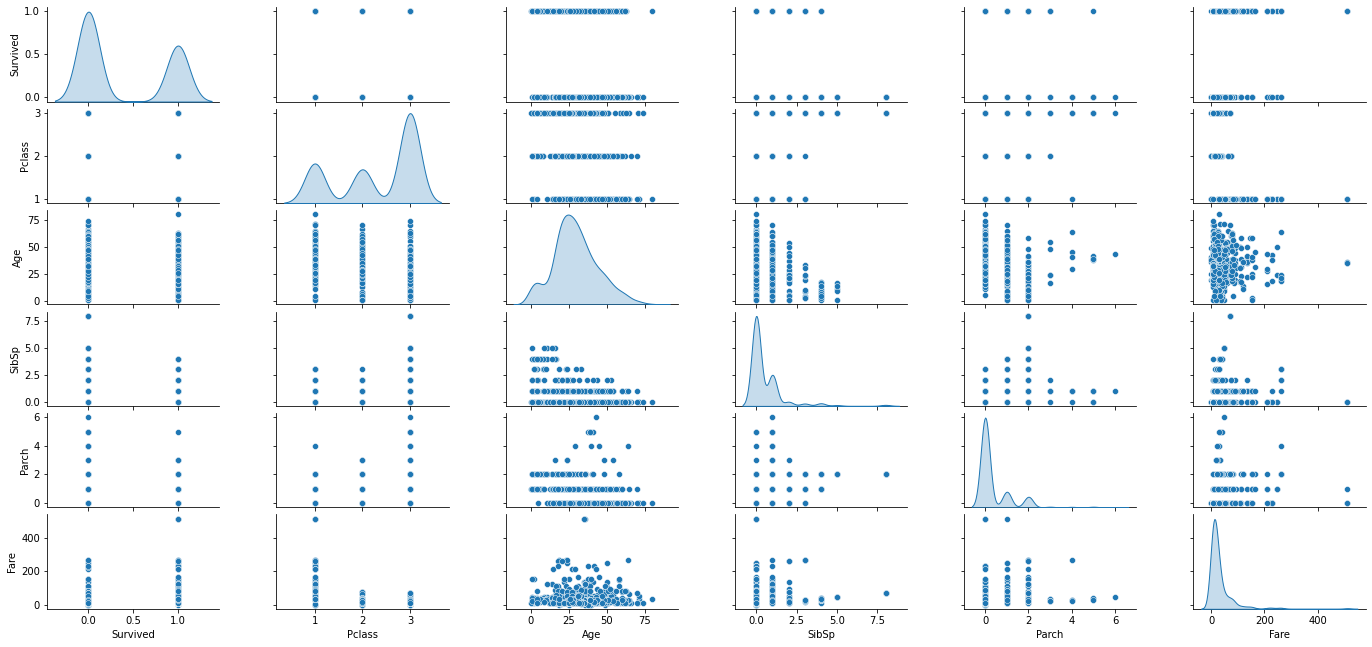

In [15]:
pp = sns.pairplot(df, size=1.8, aspect=1.8, diag_kind='kde', diag_kws=dict(shade=True))
fig = pp.fig
fig.subplots_adjust(top=0.83, wspace=0.33)

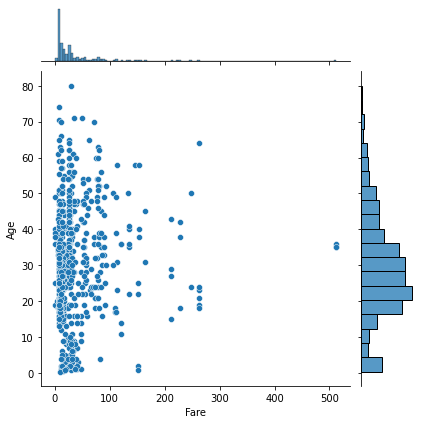

In [16]:
sns.jointplot(x=df['Fare'], y=df['Age'])

In [17]:
df[df['Fare'] > 200]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,0,1,male,19.0,3,2,19950,263.0000,C23 C25 C27,S
88,1,1,female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,0,1,male,24.0,0,1,PC 17558,247.5208,B58 B60,C
258,1,1,female,35.0,0,0,PC 17755,512.3292,NaN,C
299,1,1,female,50.0,0,1,PC 17558,247.5208,B58 B60,C
311,1,1,female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
341,1,1,female,24.0,3,2,19950,263.0000,C23 C25 C27,S
377,0,1,male,27.0,0,2,113503,211.5000,C82,C
380,1,1,female,42.0,0,0,PC 17757,227.5250,NaN,C
438,0,1,male,64.0,1,4,19950,263.0000,C23 C25 C27,S


In [18]:
idx = df[df['Fare'] > 500].index 
df.drop(idx, inplace=True)

In [19]:
idx = df[df['Age'] < 1].index
df.drop(idx, inplace=True)

Target looks like classification
Linear Discriminant Analysis training set score: 0.596


/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:376: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]
/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:376: UserWarning: FixedFormatter should only be used together with FixedLocator
  for t in ax.get_xticklabels()]


[[<Figure size 864x864 with 20 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 432x288 with 1 Axes>],
 None]

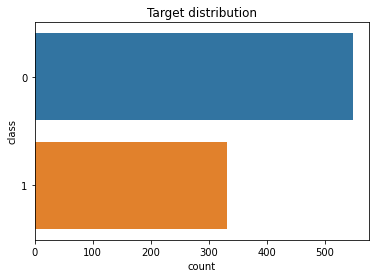

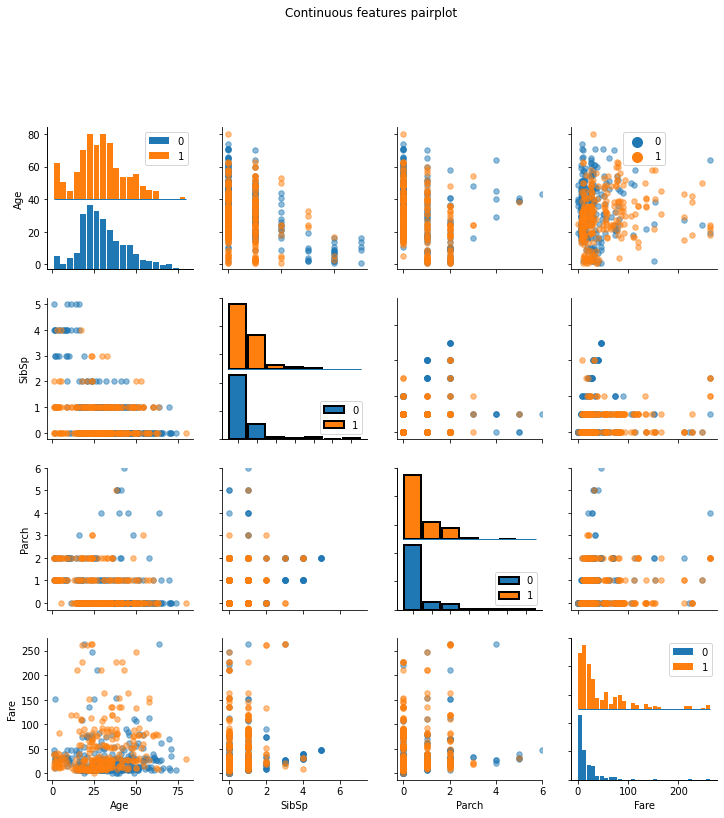

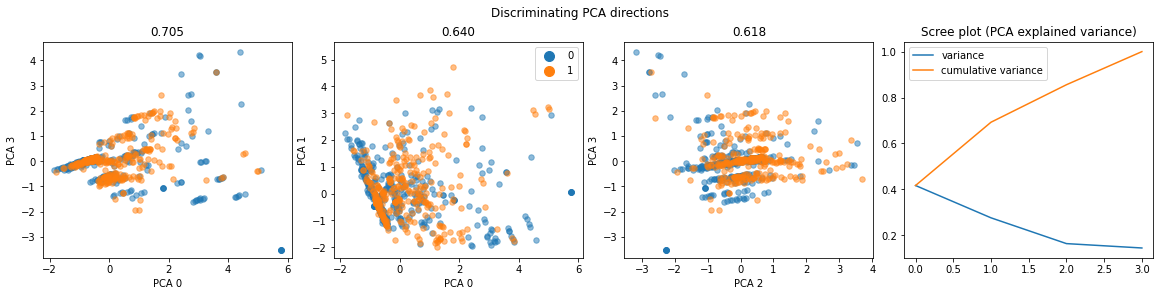

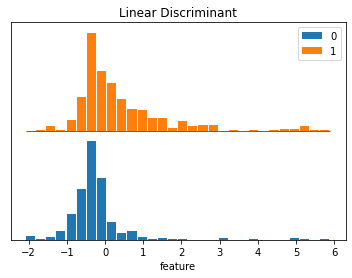

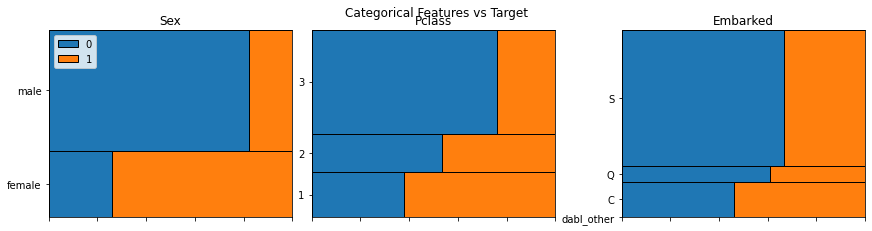

In [20]:
dabl.plot(df.drop('Survived', axis=1), df['Survived'])

### 0 -> did not survive
### 1 -> survived

# Imputation

In [21]:
df.isna().sum()[df.isna().sum() != 0]

Age         177
Cabin       680
Embarked      2
dtype: int64

In [22]:
df['Cabin'].value_counts().sum()

201

there are only 202 filled values in Cabin column, 686 values are NaN values

In [23]:
df.drop('Cabin', axis=1, inplace=True)

In [24]:
imputer = KNNImputer()
x = imputer.fit_transform(df.select_dtypes(exclude='object'))
df_filled = pd.DataFrame(data=x, columns=df.select_dtypes(exclude='object').columns)

In [25]:
df_filled.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0.0,3.0,22.0,1.0,0.0,7.2500
1,1.0,1.0,38.0,1.0,0.0,71.2833
2,1.0,3.0,26.0,0.0,0.0,7.9250
3,1.0,1.0,35.0,1.0,0.0,53.1000
4,0.0,3.0,35.0,0.0,0.0,8.0500


In [26]:
df = df.reset_index()

In [27]:
df = pd.concat([df_filled, df.select_dtypes(include='object')], axis=1)

In [28]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Ticket,Embarked
0,0.0,3.0,22.0,1.0,0.0,7.2500,male,A/5 21171,S
1,1.0,1.0,38.0,1.0,0.0,71.2833,female,PC 17599,C
2,1.0,3.0,26.0,0.0,0.0,7.9250,female,STON/O2. 3101282,S
3,1.0,1.0,35.0,1.0,0.0,53.1000,female,113803,S
4,0.0,3.0,35.0,0.0,0.0,8.0500,male,373450,S
...,...,...,...,...,...,...,...,...,...
876,0.0,2.0,27.0,0.0,0.0,13.0000,male,211536,S
877,1.0,1.0,19.0,0.0,0.0,30.0000,female,112053,S
878,0.0,3.0,26.8,1.0,2.0,23.4500,female,W./C. 6607,S
879,1.0,1.0,26.0,0.0,0.0,30.0000,male,111369,C


In [29]:
df['Embarked'].ffill(inplace=True)

In [30]:
df.isna().sum()

Survived    0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Ticket      0
Embarked    0
dtype: int64

# Encoding categorical columns

In [31]:
df.select_dtypes(include='object').columns

Index(['Sex', 'Ticket', 'Embarked'], dtype='object')

In [32]:
print('Column "Sex" has ' + str(df['Sex'].nunique()) + ' unique values')
print('Column "Ticker" has ' + str(df['Ticket'].nunique()) + ' unique values')
print('Column "Embarked" has ' + str(df['Embarked'].nunique()) + ' unique values')

Column "Sex" has 2 unique values
Column "Ticker" has 679 unique values
Column "Embarked" has 3 unique values


In [33]:
df.drop('Ticket', axis=1, inplace=True)

In [34]:
df = pd.concat([pd.get_dummies(df['Sex'], drop_first=True) , df.drop('Sex', axis=1)], axis=1)
df = pd.concat([pd.get_dummies(df['Embarked'], drop_first=True) , df.drop('Embarked', axis=1)], axis=1)

In [35]:
df.head()

,Q,S,male,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,1,1,0.0,3.0,22.0,1.0,0.0,7.2500
1,0,0,0,1.0,1.0,38.0,1.0,0.0,71.2833
2,0,1,0,1.0,3.0,26.0,0.0,0.0,7.9250
3,0,1,0,1.0,1.0,35.0,1.0,0.0,53.1000
4,0,1,1,0.0,3.0,35.0,0.0,0.0,8.0500


# Train-Test split of dataset

In [36]:
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [37]:
X.head()

,Q,S,male,Pclass,Age,SibSp,Parch,Fare
0,0,1,1,3.0,22.0,1.0,0.0,7.2500
1,0,0,0,1.0,38.0,1.0,0.0,71.2833
2,0,1,0,3.0,26.0,0.0,0.0,7.9250
3,0,1,0,1.0,35.0,1.0,0.0,53.1000
4,0,1,1,3.0,35.0,0.0,0.0,8.0500


# Preparing Test data for submission

In [38]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [39]:
test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [40]:
test_df = pd.concat([pd.get_dummies(test_df['Sex'], drop_first=True) , test_df.drop('Sex', axis=1)], axis=1)
test_df = pd.concat([pd.get_dummies(test_df['Embarked'], drop_first=True) , test_df.drop('Embarked', axis=1)], axis=1)

In [41]:
test_df.head()

,Q,S,male,Pclass,Age,SibSp,Parch,Fare
0,1,0,1,3,34.5,0,0,7.8292
1,0,1,0,3,47.0,1,0,7.0000
2,1,0,1,2,62.0,0,0,9.6875
3,0,1,1,3,27.0,0,0,8.6625
4,0,1,0,3,22.0,1,1,12.2875


# Create and Train ML model

In [42]:
xgb = XGBClassifier()
rf = RandomForestClassifier(n_estimators=30, max_depth=30, oob_score=True)
knn = KNeighborsClassifier(n_neighbors=10)

In [43]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"The model's score is: {score*100:.2f}%")
    print(classification_report(y_test, model.predict(X_test)))
    print(confusion_matrix(y_test, model.predict(X_test)))

In [44]:
train_model(xgb, X_train, y_train, X_test, y_test)

The model's score is: 86.67%
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90        29
         1.0       0.86      0.75      0.80        16

    accuracy                           0.87        45
   macro avg       0.86      0.84      0.85        45
weighted avg       0.87      0.87      0.86        45

[[27  2]
 [ 4 12]]


In [45]:
train_model(rf, X_train, y_train, X_test, y_test)

The model's score is: 82.22%
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88        29
         1.0       0.90      0.56      0.69        16

    accuracy                           0.82        45
   macro avg       0.85      0.76      0.78        45
weighted avg       0.84      0.82      0.81        45

[[28  1]
 [ 7  9]]


In [46]:
train_model(knn, X_train, y_train, X_test, y_test)

The model's score is: 66.67%
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.76        29
         1.0       0.55      0.38      0.44        16

    accuracy                           0.67        45
   macro avg       0.63      0.60      0.60        45
weighted avg       0.65      0.67      0.65        45

[[24  5]
 [10  6]]


In [47]:
print(f"Column names: {X.columns}")
xgb.feature_importances_

Column names: Index(['Q', 'S', 'male', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


array([0.02805247, 0.0322374 , 0.5917573 , 0.18412822, 0.03635938,
       0.05692942, 0.03608974, 0.03444603], dtype=float32)

<AxesSubplot:xlabel='Survived', ylabel='male'>

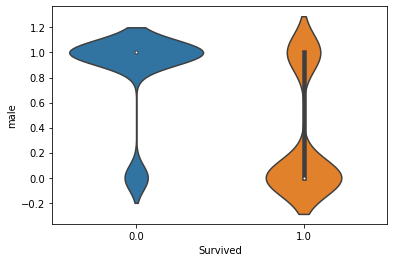

In [48]:
sns.violinplot(x=df['Survived'], y=df['male'])

# Clearly, Random Forest Classifier performed the best. So we will use this for our predictions

In [49]:
test_df.head()

,Q,S,male,Pclass,Age,SibSp,Parch,Fare
0,1,0,1,3,34.5,0,0,7.8292
1,0,1,0,3,47.0,1,0,7.0000
2,1,0,1,2,62.0,0,0,9.6875
3,0,1,1,3,27.0,0,0,8.6625
4,0,1,0,3,22.0,1,1,12.2875


In [50]:
predictions = xgb.predict(test_df)

In [51]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [52]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
